In [50]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from matplotlib import rcParams,font_manager
from matplotlib.colors import ListedColormap
import pandas as pd

In [100]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 

#ELO ratings
elo_ratings = {
 'R_3EEYoLyNN9SpuuT': 293,
 'R_1DSHShmupLFd4m9': 292,
 'R_zUdkqlxVsz3sXcJ': 258,
 'R_31SM3mwQvAhBwar': 247,
 'R_D1Afhly6eOCY66B': 242,
 'R_3fDgQlApbcv1n4e': 239,
 'R_0OFsszTuxG152et': 228,
 'R_NVGtaI93MLLVQfT': 216,
 'R_2ahKzS67s2u094R': 200,
 'R_vdABJ1XvXNriwff': 199,
 'R_2zuodaGDxpO8dfe': 172,
 'R_24rdiskqYQc7BsO': 163,
 'R_1LeQOpZ9pat1k7D': 161,
 'R_10BfVTQovUcZioM': 158,
 'R_2q8z9DfvMUHDZio': 149,
 'R_3j2tErwVrBPXWAH': 147,
 'R_Q0Jd5lCBrQu5Dm9': 147,
 'R_3lJsCIPqfpqRhkf': 146,
 'R_25zHKt5eqk2Fr1k': 139,
 'R_3kzZPXnjFGbpt30': 136,
 'R_2XpQzVOPaMJjkCo': 130,
 'R_1im5d5ENT1vk0Xm': 116,
 'R_3jciZNiYxaSffqd': 114,
 'R_2vjnTMhG0Bpa7wq': 108,
 'R_shhEOP9BPIFkz97': 93,
 'R_3oHOHstFKN4HiLA': 91,
 'R_1NCzjmN3Hl5r3HF': 80,
 'R_2OHMsGSLXJZG0Bc': 65,
 'R_z1hBUlYMwkfdbGh': 54,
 'R_r2BwOdT2hnmQ5WN': 49,
 'R_XEQd4AtPvWuAWnT': 32,
 'R_2X1ycnpBX7zJOwI': 20,
 'R_2zoxitKzRuYUblm': 14,
 'R_WBOZ0yrZfLTCClz': -21,
 'R_3ilNhJufw9u0JJr': -26,
 'R_1OGFPUUh0z8rWBh': -50,
 'R_2TTetTXWqRwQOGb': -70,
 'R_9Nac2hjg6u7BlS1': -88,
 'R_0voL9dLPRpILrS9': -158,
 'R_2xV1IwgJyplwuvp': -159,
 'R_bqny5leXGykyp0t': -161,
 'R_1F5MGuZ2rKZOLnc': -173,
 'R_2D6PtBpvztH0yVh': -185}

usernames = ['A112:R_1DSHShmupLFd4m9','A101:R_Q0Jd5lCBrQu5Dm9', 'A121:R_3j2tErwVrBPXWAH', 
             'A1083:R_0OFsszTuxG152et', 'A103:R_3lJsCIPqfpqRhkf', 'A130:R_zUdkqlxVsz3sXcJ',
            '101:R_31SM3mwQvAhBwar', '102:R_vdABJ1XvXNriwff', '107:R_2ahKzS67s2u094R',
            '117:R_2XpQzVOPaMJjkCo', '121:R_2zoxitKzRuYUblm', '129:R_2q8z9DfvMUHDZio',
            '139:R_1F5MGuZ2rKZOLnc', '152:R_XEQd4AtPvWuAWnT', '149:R_shhEOP9BPIFkz97', '150:R_3ilNhJufw9u0JJr',
            '156:R_2TTetTXWqRwQOGb', '166:R_9Nac2hjg6u7BlS1', '137:R_2X1ycnpBX7zJOwI',
            '256:R_10BfVTQovUcZioM', '175:R_2vjnTMhG0Bpa7wq', '181:R_3fDgQlApbcv1n4e',
            '187:R_3oHOHstFKN4HiLA', '192:R_1LeQOpZ9pat1k7D', '199:R_D1Afhly6eOCY66B',
             '201:R_3kzZPXnjFGbpt30', '202:R_2OHMsGSLXJZG0Bc', '200:R_1NCzjmN3Hl5r3HF',
             '194:R_24rdiskqYQc7BsO', '196:R_0voL9dLPRpILrS9', '197:R_bqny5leXGykyp0t',
             '179:R_2xV1IwgJyplwuvp', '180:R_1OGFPUUh0z8rWBh', '250:R_r2BwOdT2hnmQ5WN',
             '273:R_2zuodaGDxpO8dfe', '281:R_NVGtaI93MLLVQfT', '290:R_25zHKt5eqk2Fr1k',
             '305:R_WBOZ0yrZfLTCClz', '842:R_3jciZNiYxaSffqd',
             '846:R_z1hBUlYMwkfdbGh', '844:R_2D6PtBpvztH0yVh', '849:R_1im5d5ENT1vk0Xm',
             '856:R_3EEYoLyNN9SpuuT', '149:R_shhEOP9BPIFkz97', '150:R_3ilNhJufw9u0JJr',
             '156:R_2TTetTXWqRwQOGb', '166:R_9Nac2hjg6u7BlS1', '137:R_2X1ycnpBX7zJOwI'
             ]
psiturkid2username = {username.split(":")[1]: username for username in usernames}
studyid2username = {username.split(":")[0]: username for username in usernames}
username2studyid = {username: username.split(":")[0] for username in usernames}
username2psiturkid = {username: username.split(":")[1] for username in usernames}

In [103]:
datadir = "./"
age = pd.read_csv(datadir + "demog_12_9.csv")
pwm = pd.read_csv(datadir + "params_with_metrics.csv").rename(columns = {"0": "subject_nr", "1": "split"})
dur = pd.read_csv(datadir + "gameDurations.csv")

bins = [7, 12, 18, 26]
age["username"] = age["StudyID"].apply(lambda id: studyid2username.get(id, "-"))
age['ageBin'] = pd.cut(age['FlooredAge'], bins)
age['ageBinNr'] = age['ageBin'].cat.codes
metrics = pwm.loc[:,("subject_nr", "split", "planning depth", "feature drop rate", "heuristic quality")]
metrics.loc[:,"username"] = metrics["subject_nr"].apply(lambda nr: usernames[nr - 1])
metrics = pd.merge(metrics, age, on="username", how="left")
metrics["elo"] = metrics["username"].apply(lambda name: elo_ratings[username2psiturkid[name]])
metrics

,subject_nr,split,planning depth,feature drop rate,heuristic quality,username,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,elo
0,1,1,8.13583,0.436090,0.638619,A112:R_1DSHShmupLFd4m9,A112,2/24/01,F,19.6904,19,10/29/20,"(18, 26]",2,292
1,1,2,2.92211,0.273650,0.559960,A112:R_1DSHShmupLFd4m9,A112,2/24/01,F,19.6904,19,10/29/20,"(18, 26]",2,292
2,1,3,0.04544,0.055475,0.596631,A112:R_1DSHShmupLFd4m9,A112,2/24/01,F,19.6904,19,10/29/20,"(18, 26]",2,292
3,1,4,9.13304,0.162850,0.525318,A112:R_1DSHShmupLFd4m9,A112,2/24/01,F,19.6904,19,10/29/20,"(18, 26]",2,292
4,1,5,0.00000,0.312920,0.616708,A112:R_1DSHShmupLFd4m9,A112,2/24/01,F,19.6904,19,10/29/20,"(18, 26]",2,292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,48,1,2.21188,0.485960,0.591622,137:R_2X1ycnpBX7zJOwI,137,10/23/09,F,11.0849,11,11/20/20,"(7, 12]",0,20
236,48,2,8.15202,0.341490,0.706751,137:R_2X1ycnpBX7zJOwI,137,10/23/09,F,11.0849,11,11/20/20,"(7, 12]",0,20
237,48,3,3.46447,0.647700,0.658019,137:R_2X1ycnpBX7zJOwI,137,10/23/09,F,11.0849,11,11/20/20,"(7, 12]",0,20
238,48,4,3.06731,0.315760,0.656761,137:R_2X1ycnpBX7zJOwI,137,10/23/09,F,11.0849,11,11/20/20,"(7, 12]",0,20


In [113]:
age_colors = ['#7DE3AC', '#129951','#20382B']

def set_labels(ax, title):
    ax.set_xlabel("Age")
    ax.set_ylabel(title)
    labels = ["8 to 12","13 to 18","19 to 26"]
    if len(ax.xaxis.get_major_locator()()) == 5:
        labels.insert(0, "")
        labels.append("")
    ax.set_xticklabels(labels)
    ax.legend([])
    return ax

def plot_with_errorbars(col, title):
    ax = metrics.groupby("ageBin")[col].aggregate(['mean', 'sem']).plot(yerr="sem", color='k')
    size = 300
    metrics.groupby("ageBinNr")[col].aggregate(['mean']).reset_index().plot.scatter('ageBinNr', 'mean', size, age_colors, ax=ax)
#     circles = metrics.loc[:,("subject_nr","ageBinNr",col)].drop_duplicates()
#     circles.plot.scatter("ageBinNr", col, ax=ax)
    set_labels(ax, title)

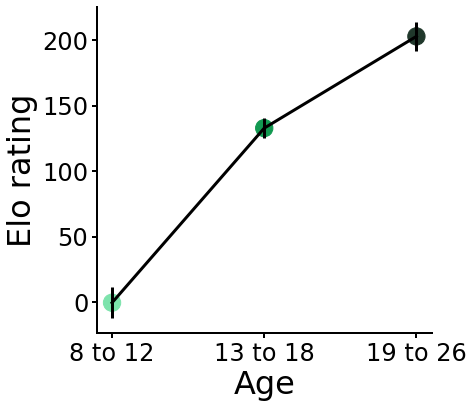

In [114]:
plot_with_errorbars("elo", "Elo rating")

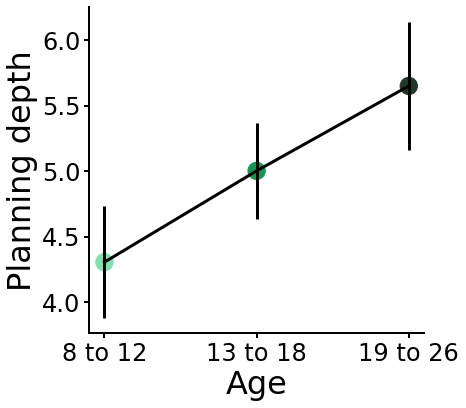

In [115]:
plot_with_errorbars("planning depth", "Planning depth")

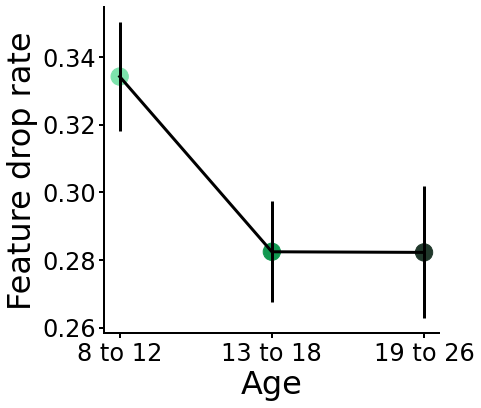

In [116]:
plot_with_errorbars("feature drop rate", "Feature drop rate")

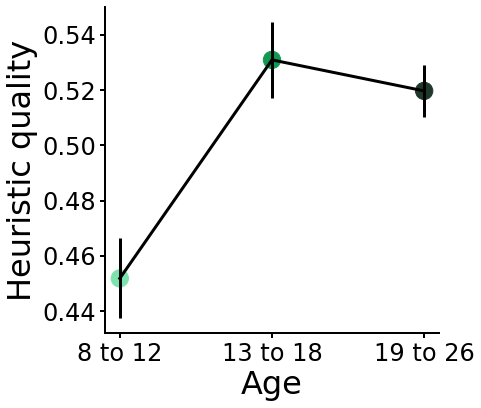

In [117]:
plot_with_errorbars("heuristic quality", "Heuristic quality")

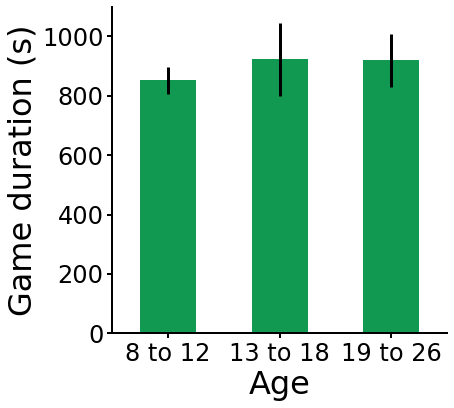

In [163]:
ax = pd.merge(dur, age, how="left", left_on="User", right_on="username").groupby("ageBin")["DurationSeconds"].aggregate(['mean', 'sem']).plot(kind="bar", yerr="sem", color='#129951')
set_labels(ax, "Game duration (s)").tick_params("x", labelrotation=0)